In [12]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./data/co2.csv')
df.head()

,Day,time,vco2,si13c,tracer,cage,enrich,tracer_umol_min,co2_flux,recovery
0,2,-352,1.249430,-11.785750,glucose,1,-0.000107,2.04120,-0.005979,-0.003255
1,2,-356,1.696254,-10.642560,lactate,2,-0.000095,1.56240,-0.007166,-0.005096
2,2,-362,1.689503,-8.962937,3hb,3,-0.000076,0.40160,-0.005745,-0.015896
3,2,-367,1.515335,-5.852248,glucose,4,-0.000042,2.17560,-0.002840,-0.001451
4,2,-373,2.085561,-8.653533,lactate,5,-0.000073,1.81629,-0.006776,-0.004145


<AxesSubplot: xlabel='time', ylabel='vco2'>

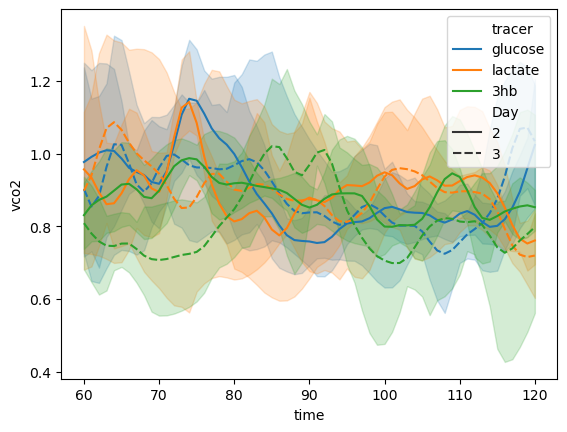

In [20]:
# Plot time series data
data = df[ (df.time >= 60) & (df.time <= 120) ] 
sns.lineplot(data=data, x='time', y='vco2', style='Day', hue='tracer')

In [3]:
data = df[ (df.time >= 60) & (df.time <= 150) ] 
data['vco2_umol_min'] = data['vco2'].astype(float) * 1000/22.4

# Average over an hour per Day, cage and tracer
data = data.groupby(['Day', 'cage','tracer']).mean().reset_index()

/tmp/ipykernel_28038/2582431683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vco2_umol_min'] = data['vco2'].astype(float) * 1000/22.4


In [4]:
data

,Day,cage,tracer,time,vco2,si13c,enrich,tracer_umol_min,co2_flux,recovery,vco2_umol_min
0,2,1,glucose,120.0,0.937140,2554.340279,0.027304,2.04120,1.142832,0.622092,41.836603
1,2,2,lactate,120.0,0.871280,2662.328836,0.028435,1.56240,1.101514,0.783349,38.896414
2,2,3,3hb,120.0,0.898166,661.725907,0.007241,0.40160,0.288637,0.798575,40.096682
3,2,4,glucose,120.0,0.891853,2435.005541,0.026064,2.17560,1.043594,0.532979,39.814872
4,2,5,lactate,120.0,0.983747,2686.822213,0.028680,1.81629,1.263692,0.773061,43.917272
5,2,6,3hb,120.0,0.914692,672.900125,0.007361,0.43200,0.299435,0.770153,40.834474
6,2,9,glucose,120.0,0.798941,4125.131098,0.043351,2.31840,1.552463,0.744030,35.667001
7,2,10,lactate,120.0,1.011946,2489.525623,0.026641,1.66005,1.195601,0.800245,45.176175
8,2,11,3hb,120.0,0.841064,590.085592,0.006464,0.38720,0.241148,0.691998,37.547492
9,2,12,glucose,120.0,0.839063,2940.045607,0.031296,1.89000,1.169634,0.687616,37.458156


/tmp/ipykernel_28038/325584338.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontfamily='Arial')
/tmp/ipykernel_28038/325584338.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontfamily='Arial')
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ari

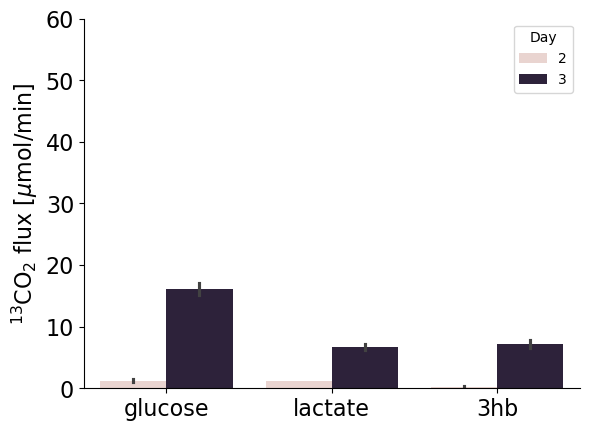

In [5]:
f = plt.figure()
ax = sns.barplot(data=data, x='tracer', y='co2_flux', hue='Day', errorbar='sd')
plt.ylim(0, 60)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontfamily='Arial')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontfamily='Arial')
ax.set_ylabel('$\mathrm{^{13}CO_2}$ flux [$\mu$mol/min]', fontsize=16, fontfamily='Arial')
ax.set_xlabel('', fontsize=16, fontfamily='Arial')

# Remove spines on the right and top
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



/tmp/ipykernel_28038/157252704.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontfamily='Arial')
/tmp/ipykernel_28038/157252704.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontfamily='Arial')
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont:

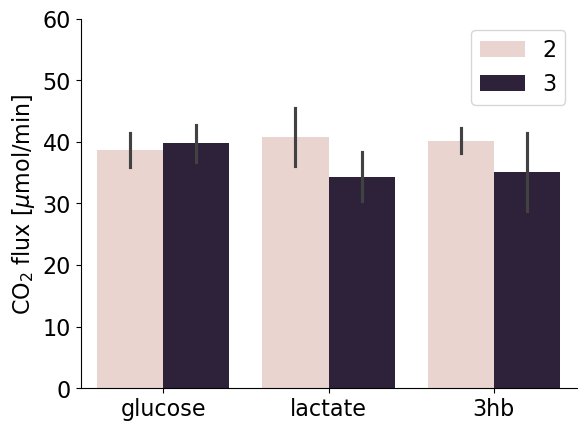

In [6]:
f = plt.figure()
ax = sns.barplot(data=data, x='tracer', y ='vco2_umol_min', hue='Day', errorbar='sd')
plt.ylim(0, 60)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontfamily='Arial')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontfamily='Arial')
ax.set_ylabel('$\mathrm{CO_2}$ flux [$\mu$mol/min]', fontsize=16, fontfamily='Arial')
ax.set_xlabel('', fontsize=16, fontfamily='Arial')
ax.legend(fontsize=16, title_fontsize=16)

# Remove spines on the right and top
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

